# モデル選択

In [ ]:
# model_path = 'openbmb/MiniCPM-V-2_6'  # L4 GPU以上のGPUが必要
model_path = 'openbmb/MiniCPM-V-2_6-int4'  # T4 GPU以上のGPUが必要

In [ ]:
# !git clone https://github.com/OpenBMB/MiniCPM-V.git
# %cd MiniCPM-V

# パッケージインストール

In [ ]:
!pip install transformers==4.40.0
!pip install -U flash_attn
!pip install sentencepiece==0.1.99
!pip install accelerate==0.30.1
!pip install bitsandbytes==0.43.1
!pip install -U timm

# モデル読み込み

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

torch.manual_seed(0)

model_name = model_path.split('/')[-1]
if model_name == 'MiniCPM-V-2_6':
    attn_implementation = 'sdpa'  # sdpa or flash_attention_2, no eager
    torch_dtype = torch.bfloat16
elif model_name == 'MiniCPM-V-2_6-int4':
    attn_implementation = None
    torch_dtype = None

model = AutoModel.from_pretrained(
    model_path,
    trust_remote_code=True,
    attn_implementation=attn_implementation,
    torch_dtype=torch_dtype,
)
if model_name == 'MiniCPM-V-2_6':
    model = model.eval().cuda()
elif model_name == 'MiniCPM-V-2_6-int4':
    model = model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

In [ ]:
_ = model.chat(
    image=None,
    msgs=[{'role': 'user', 'content': ['']}],
    tokenizer=tokenizer,
)

# 画像認識でのマルチターンチャット サンプル

## サンプル画像ダウンロード

In [ ]:
!wget https://raw.githubusercontent.com/Kazuhito00/MiniCPM-V2.6-Colaboratory-Sample/main/assets/sample01.jpg -O sample01.jpg

In [ ]:
import cv2
from PIL import Image

cv_image = cv2.imread('sample01.jpg')
rgb_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
pil_image = Image.fromarray(rgb_image)

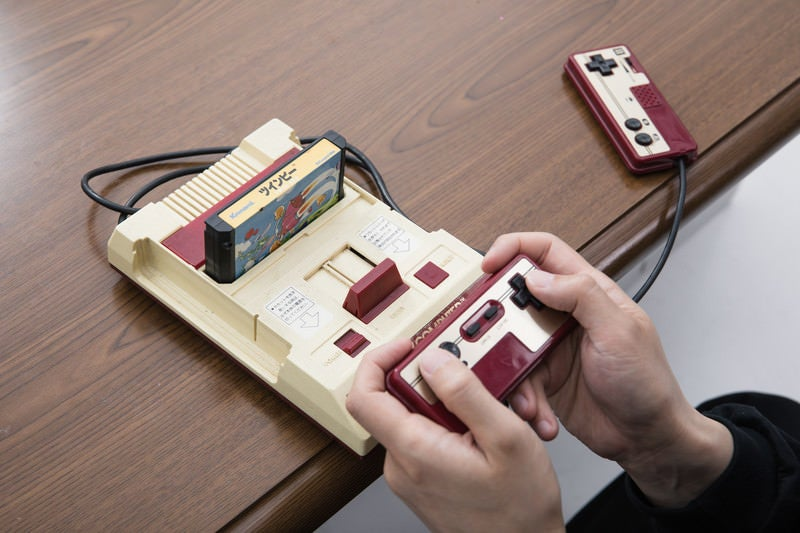

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(cv_image)

## 初回チャット

In [ ]:
%%time

question = "explain this image."
msgs = [{'role': 'user', 'content': [pil_image, question]}]

answer = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer,
)
print(answer)

In the center of this image, a pair of hands is seen holding a red and white handheld gaming device. The device has a joystick on the right side, indicating it's designed for one-handed use. On the left side, there are two buttons, possibly used for different actions in the game.

The background features a wooden table, providing a contrast to the vibrant colors of the gaming device. On the top left corner of the table, there's a beige-colored console with a black cord attached to it, suggesting that it might be connected to another device or power source.

The overall scene suggests a moment of leisure, perhaps someone preparing to play a game using the handheld device. The presence of the console could indicate a setup where multiple games can be played through different devices. However, without additional context, these interpretations remain speculative.
CPU times: user 14.2 s, sys: 603 ms, total: 14.8 s
Wall time: 14.8 s


## 2回目チャット（1回目の回答を渡し、追加の質問を行う）

In [ ]:
%%time

msgs.append({"role": "assistant", "content": [answer]})
msgs.append({"role": "user", "content": ["tell me more about the cartridge."]})

answer = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer
)
print(answer)

The cartridge is a component of the handheld gaming device. It's colored red and white, matching the overall color scheme of the device. Cartridges like this one typically contain pre-installed games or software that can be played on compatible devices. The specific details about the game or software inside this particular cartridge aren't visible in the image, but it's clear that it plays an essential role in providing entertainment through the handheld console.
CPU times: user 9.19 s, sys: 899 ms, total: 10.1 s
Wall time: 10 s


# 複数画像認識 サンプル

## サンプル画像ダウンロード

In [ ]:
!wget https://raw.githubusercontent.com/Kazuhito00/MiniCPM-V2.6-Colaboratory-Sample/main/assets/sample02.jpg -O sample02-01.jpg
!wget https://raw.githubusercontent.com/Kazuhito00/MiniCPM-V2.6-Colaboratory-Sample/main/assets/sample03.jpg -O sample02-02.jpg

In [ ]:
cv_image01 = cv2.imread('sample02-01.jpg')
pil_image01 = Image.fromarray(cv2.cvtColor(cv_image01, cv2.COLOR_BGR2RGB))

cv_image02 = cv2.imread('sample02-02.jpg')
pil_image02 = Image.fromarray(cv2.cvtColor(cv_image02, cv2.COLOR_BGR2RGB))

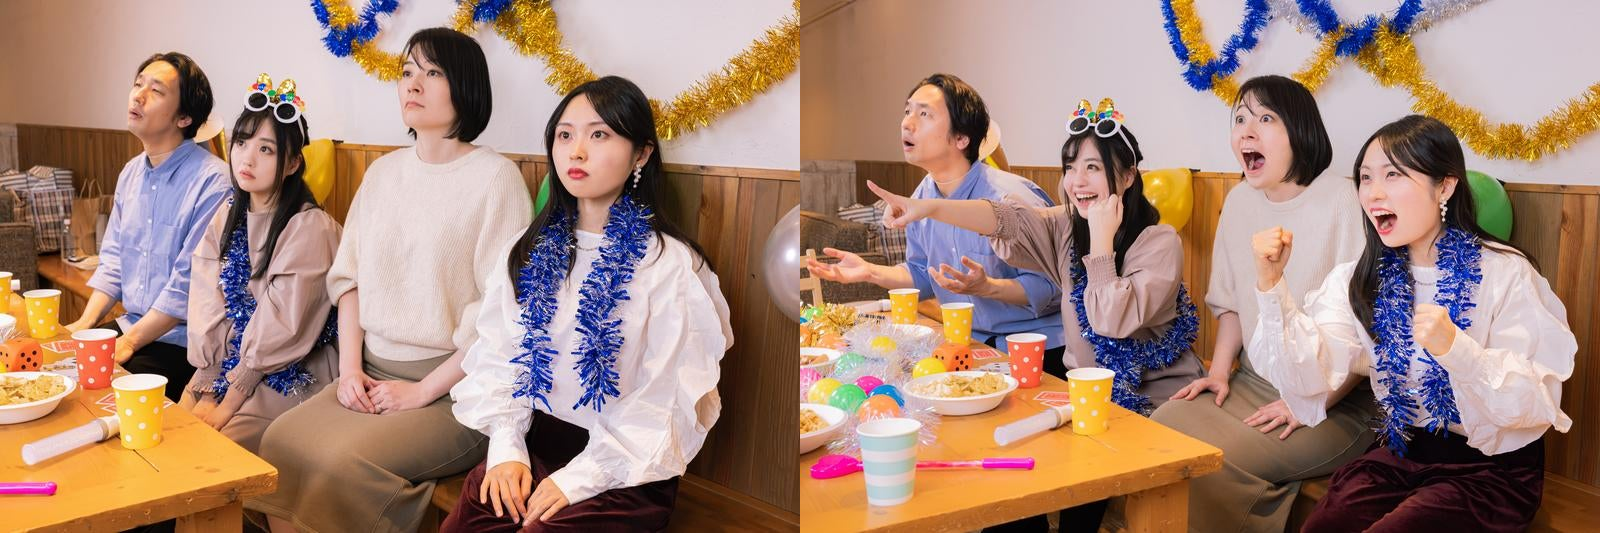

In [ ]:
from google.colab.patches import cv2_imshow
debug_image = cv2.hconcat([cv_image01, cv_image02])
cv2_imshow(debug_image)

## 2枚の画像を渡し、画像の違いを説明させる

In [ ]:
question = 'Compare image 1 and image 2, tell me about the differences between image 1 and image 2.'
msgs = [{'role': 'user', 'content': [pil_image01, pil_image02, question]}]

answer = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer
)
print(answer)

In the second image, one of the individuals has their arm extended with a clenched fist, indicating a gesture of celebration or victory. This detail is not present in the first image where all individuals have their arms down and relaxed.


# 動画認識 サンプル

## サンプル動画ダウンロード

In [ ]:
!wget https://raw.githubusercontent.com/Kazuhito00/MiniCPM-V2.6-Colaboratory-Sample/main/assets/sample.mp4 -O sample.mp4

## 動画前処理用関数

In [ ]:
def preprocess_video(video_path, max_num_frames=64):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # サンプリング間隔を計算
    sample_fps = round(fps)
    frame_idx = [i for i in range(0, total_frames, sample_fps)]

    # 必要に応じてフレーム数を制限
    def uniform_sample(l, n):
        gap = len(l) / n
        idxs = [int(i * gap + gap / 2) for i in range(n)]
        return [l[i] for i in idxs]
    if len(frame_idx) > max_num_frames:
        print('uniform_sample() 実行')
        frame_idx = uniform_sample(frame_idx, max_num_frames)

    print('frame_idx:', frame_idx)
    print('フレーム間隔（秒）:', int((frame_idx[-1] - frame_idx[-2]) / sample_fps))

    # PIL Image形式でリストに格納
    frames = []
    for idx in frame_idx:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(Image.fromarray(frame))

    cap.release()

    print('フレーム数:', len(frames))
    return frames

## 動画解析

In [ ]:
video_path="sample.mp4"
frames = preprocess_video(video_path)

question = "describe the video"
msgs = [
    {'role': 'user', 'content': frames + [question]},
]
params = {}
params["use_image_id"] = False
params["max_slice_nums"] = 1  # 通常は2を指定し、CUDAメモリオーバーやビデオ解像度が448x448を越える場合1を指定

answer = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer,
    **params
)
print(answer)

frame_idx: [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570, 600, 630, 660, 690, 720, 750, 780, 810, 840, 870, 900, 930, 960, 990, 1020, 1050, 1080, 1110, 1140, 1170, 1200, 1230, 1260, 1290, 1320, 1350, 1380, 1410, 1440, 1470, 1500, 1530, 1560, 1590, 1620, 1650, 1680, 1710, 1740, 1770, 1800, 1830, 1860]
フレーム間隔（秒）: 1
フレーム数: 63
The video begins with a wide shot of a Qantas airplane on the runway, followed by a close-up of a cheerful koala character logo. It transitions to scenic shots of Mount Fuji and people admiring it, suggesting a possible travel or tourism context. The focus then shifts to an outdoor setting where individuals interact with animals, including feeding a giraffe and observing kangaroos in their enclosures. The footage includes various angles of the animals' interactions within their habitats.

The narrative progresses to an indoor event celebrating "Koala Day," as indicated by banners and decorations. Attendees are shown en

# コンテキスト内でのフューショット学習 サンプル

## サンプル画像ダウンロード

In [ ]:
!wget https://raw.githubusercontent.com/Kazuhito00/MiniCPM-V2.6-Colaboratory-Sample/main/assets/sample03-01.jpg -O sample03-01.jpg
!wget https://raw.githubusercontent.com/Kazuhito00/MiniCPM-V2.6-Colaboratory-Sample/main/assets/sample03-02.jpg -O sample03-02.jpg
!wget https://raw.githubusercontent.com/Kazuhito00/MiniCPM-V2.6-Colaboratory-Sample/main/assets/sample03-03.jpg -O sample03-03.jpg

In [ ]:
cv_image03_01 = cv2.imread('sample03-01.jpg')
pil_image03_01 = Image.fromarray(cv2.cvtColor(cv_image03_01, cv2.COLOR_BGR2RGB))

cv_image03_02 = cv2.imread('sample03-02.jpg')
pil_image03_02 = Image.fromarray(cv2.cvtColor(cv_image03_02, cv2.COLOR_BGR2RGB))

cv_image03_03 = cv2.imread('sample03-03.jpg')
pil_image03_03 = Image.fromarray(cv2.cvtColor(cv_image03_03, cv2.COLOR_BGR2RGB))

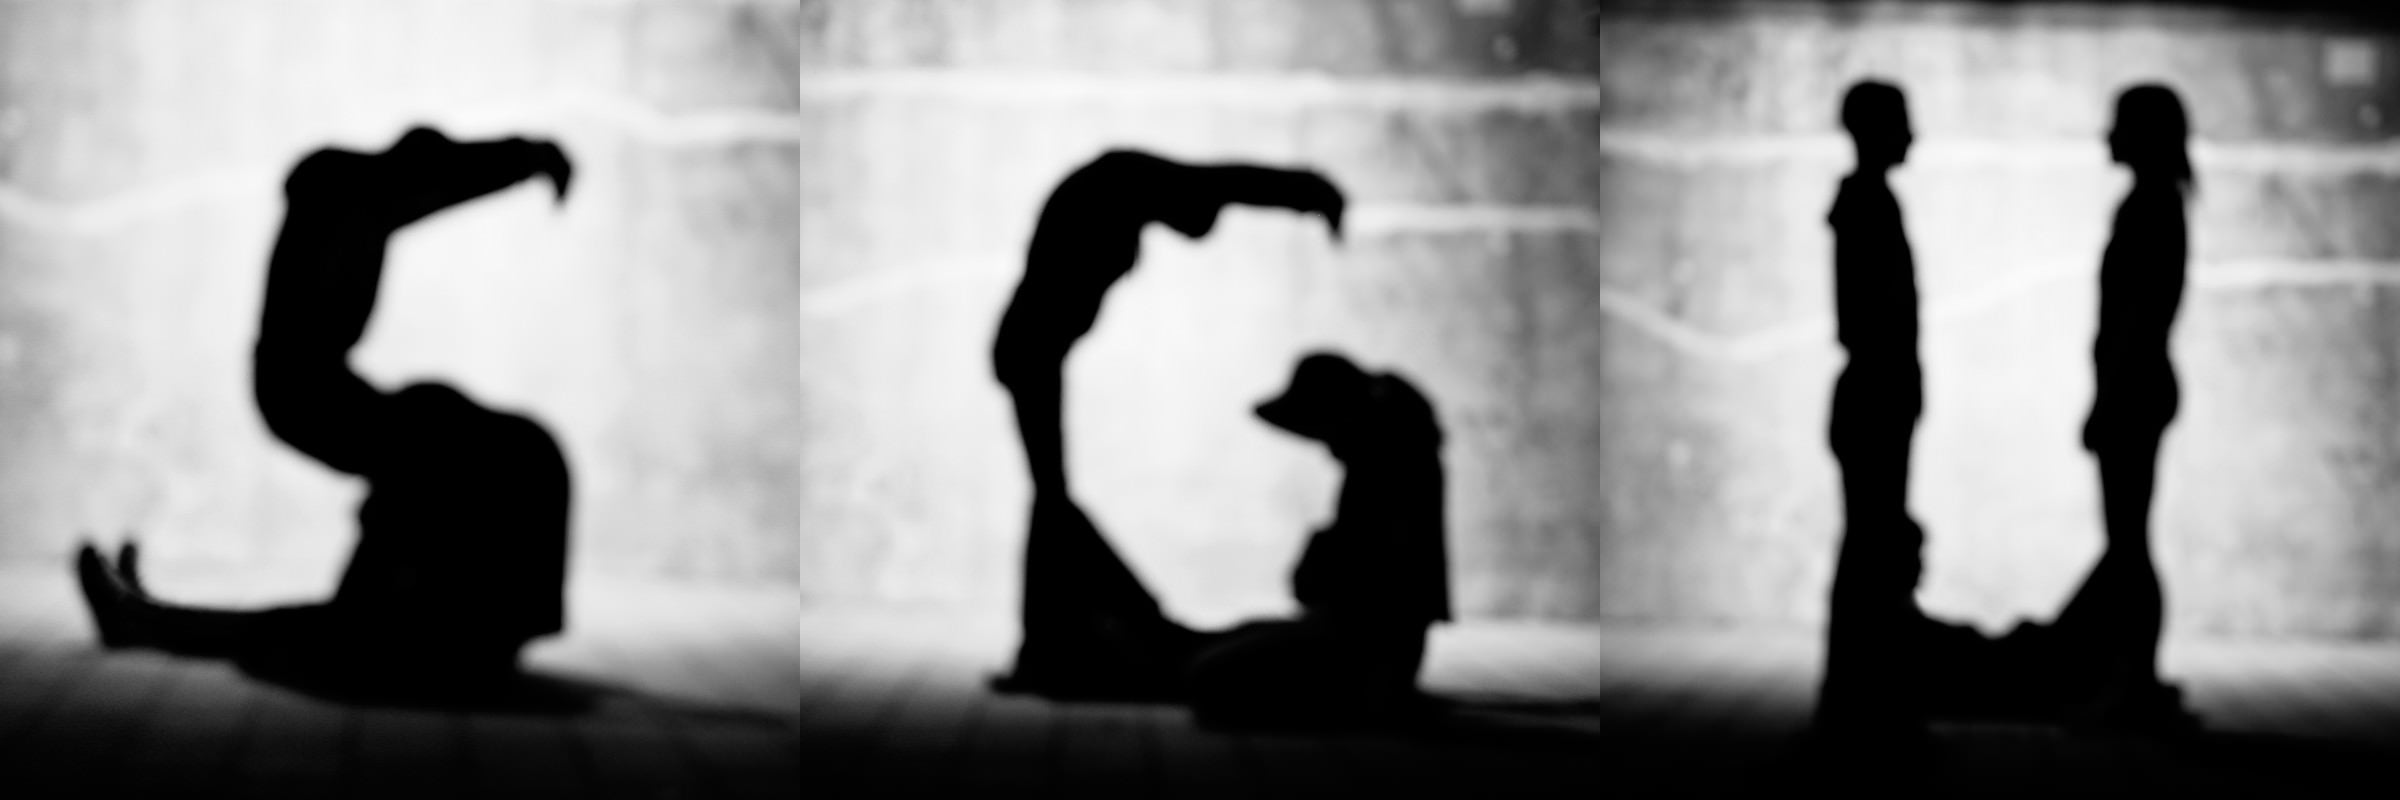

In [ ]:
from google.colab.patches import cv2_imshow
debug_image = cv2.hconcat([cv_image03_01, cv_image03_02])
debug_image = cv2.hconcat([debug_image, cv_image03_03])
cv2_imshow(debug_image)

## 回答例の学習なしでの質問

In [ ]:
question = "What does this picture represent?"
msgs = [{'role': 'user', 'content': [pil_image03_03, question]}]

answer = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer,
)
print(answer)

The image is a silhouette of two people standing side by side, facing each other. The background appears to be blurred with horizontal lines, possibly indicating a wall or a textured surface behind them. The overall composition creates an abstract and somewhat mysterious visual effect due to the lack of color and detail in the photograph.


## 回答例の学習ありでの質問

In [ ]:
ありquestion = "What does this picture represent?"
answer1 = "S"
answer2 = "G"
msgs = [
    {'role': 'user', 'content': [pil_image03_01, question]}, {'role': 'assistant', 'content': [answer1]},
    {'role': 'user', 'content': [pil_image03_02, question]}, {'role': 'assistant', 'content': [answer2]},
    {'role': 'user', 'content': [pil_image03_03, question]}
]

answer = model.chat(
    image=None,
    msgs=msgs,
    tokenizer=tokenizer
)
print(answer)

U
